# Wide and Deep Recommender System - Expedia Hotel dataset

## Import Libraries

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf
import warnings
import math
import sys

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from math import sqrt


from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense

from deepctr.inputs import build_input_features, get_linear_logit, input_from_feature_columns, combined_dnn_input
from deepctr.layers.core import PredictionLayer, DNN
from deepctr.layers.utils import add_func
from deepctr.models import WDL


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from deepctr.inputs import SparseFeat,get_feature_names

In [22]:
df = pd.read_csv('/Users/yas/Downloads/github/recommender_system/data/hotel_data/train.csv', sep=',', nrows=100000)
df.shape

(100000, 24)

## Data Preprocessing

In [23]:
df.head(n=2)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
date_time                    100000 non-null object
site_name                    100000 non-null int64
posa_continent               100000 non-null int64
user_location_country        100000 non-null int64
user_location_region         100000 non-null int64
user_location_city           100000 non-null int64
orig_destination_distance    63078 non-null float64
user_id                      100000 non-null int64
is_mobile                    100000 non-null int64
is_package                   100000 non-null int64
channel                      100000 non-null int64
srch_ci                      99929 non-null object
srch_co                      99929 non-null object
srch_adults_cnt              100000 non-null int64
srch_children_cnt            100000 non-null int64
srch_rm_cnt                  100000 non-null int64
srch_destination_id          100000 non-null int64
srch_destination_type

### drop orig_destination_distance and null values.

In [25]:
df= df.drop(['orig_destination_distance'],axis=1)

In [26]:
df = df.dropna()

In [27]:
df= df.drop(['date_time'],axis=1)
df= df.drop(['srch_ci'],axis=1)
df= df.drop(['srch_co'],axis=1)
df= df.drop(['srch_destination_id'],axis=1)

In [28]:
#Define an information dectionary for features
info_dic = {'date_time':'Timestamp',
'site_name':'ID of the Expedia point of sale (i.e. Expedia.com, Expedia.co.uk, Expedia.co.jp, …)',
'posa_continent':'ID of continent associated with site_name',
'user_location_country':'The ID of the country the customer is located',
'user_location_region':'The ID of the region the customer is located',
'user_location_city':'The ID of the city the customer is located',
'orig_destination_distance':'Physical distance between a hotel and a customer at the time of search. A null means the distance could not be calculated',
'user_id':'ID of user','is_mobile':'1 when a user connected from a mobile device, 0 otherwise',
'is_package':'1 if the click/booking was generated as a part of a package (i.e. combined with a flight), 0 otherwise',
'channel':'ID of a marketing channel',
'srch_ci':'Checkin date','srch_co':'Checkout date',
'srch_adults_cnt':'The number of adults specified in the hotel room',
'srch_children_cnt':'The number of (extra occupancy) children specified in the hotel room',
'srch_rm_cnt':'The number of hotel rooms specified in the search',
'srch_destination_id':'ID of the destination where the hotel search was performed',
'srch_destination_type_id':'Type of destination','hotel_continent':'Hotel continent',
'hotel_country':'Hotel country',
'hotel_market':'Hotel market','is_booking':'1 if a booking, 0 if a click',
'cnt':'Numer of similar events in the context of the same user session','hotel_cluster':'ID of a hotel cluster'}

In [47]:
# rename 2 columns
df = df.rename(columns={'hotel_cluster': 'item_id', 'is_booking': 'rating'})

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99929 entries, 0 to 99999
Data columns (total 19 columns):
site_name                   99929 non-null float64
posa_continent              99929 non-null float64
user_location_country       99929 non-null float64
user_location_region        99929 non-null float64
user_location_city          99929 non-null float64
user_id                     99929 non-null int64
is_mobile                   99929 non-null int64
is_package                  99929 non-null int64
channel                     99929 non-null float64
srch_adults_cnt             99929 non-null float64
srch_children_cnt           99929 non-null float64
srch_rm_cnt                 99929 non-null float64
srch_destination_type_id    99929 non-null float64
rating                      99929 non-null int64
cnt                         99929 non-null float64
hotel_continent             99929 non-null float64
hotel_country               99929 non-null float64
hotel_market                9992

In [49]:
info_dic['srch_destination_id']

'ID of the destination where the hotel search was performed'

In [50]:
df.shape

(99929, 19)

In [51]:
df.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_type_id,rating,cnt,hotel_continent,hotel_country,hotel_market,item_id
0,0.0,0.75,0.276151,0.339512,0.864884,0,0,1,0.9,0.222222,0.0,0.125,0.0,0,0.034483,0.333333,0.235849,0.296646,1
1,0.0,0.75,0.276151,0.339512,0.864884,0,0,1,0.9,0.222222,0.0,0.125,0.0,1,0.000000,0.333333,0.235849,0.296646,1
2,0.0,0.75,0.276151,0.339512,0.864884,0,0,0,0.9,0.222222,0.0,0.125,0.0,0,0.000000,0.333333,0.235849,0.296646,1
3,0.0,0.75,0.276151,0.431220,0.626407,1,0,0,0.3,0.222222,0.0,0.125,0.0,0,0.000000,0.333333,0.235849,0.688238,80
4,0.0,0.75,0.276151,0.431220,0.626407,1,0,0,0.3,0.222222,0.0,0.125,0.0,0,0.000000,0.333333,0.235849,0.688238,21


In [54]:
'''#Remove rows with the same user_id and item_id and different rating

max_rating = df.groupby(['user_id', 'item_id']).rating.transform(max)
df = df.loc[df.rating == max_rating]
df.drop_duplicates(keep='first',inplace=True)'''

"#Remove rows with the same user_id and item_id and different rating\n\nmax_rating = df.groupby(['user_id', 'item_id']).rating.transform(max)\ndf = df.loc[df.rating == max_rating]\ndf.drop_duplicates(keep='first',inplace=True)"

In [55]:
sparse_features = ["item_id", "user_id","is_mobile", "is_package"]
dense_features = ['site_name', 'posa_continent', 'user_location_country',
       'user_location_region', 'user_location_city','channel', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_type_id', 'cnt',
       'hotel_continent', 'hotel_country', 'hotel_market']
target = ['rating']

### Simple preprocessing

In [56]:
# Label Encoding for sparse features,and normalization for dense numerical features
for feat in sparse_features:
    lbe = LabelEncoder()
    df[feat] = lbe.fit_transform(df[feat])

In [57]:
mms = MinMaxScaler(feature_range=(0,1))
df[dense_features] = mms.fit_transform(df[dense_features])

In [58]:
df.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,user_id,is_mobile,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_type_id,rating,cnt,hotel_continent,hotel_country,hotel_market,item_id
0,0.0,0.75,0.276151,0.339512,0.864884,0,0,1,0.9,0.222222,0.0,0.125,0.0,0,0.034483,0.333333,0.235849,0.296646,1
1,0.0,0.75,0.276151,0.339512,0.864884,0,0,1,0.9,0.222222,0.0,0.125,0.0,1,0.000000,0.333333,0.235849,0.296646,1
2,0.0,0.75,0.276151,0.339512,0.864884,0,0,0,0.9,0.222222,0.0,0.125,0.0,0,0.000000,0.333333,0.235849,0.296646,1
3,0.0,0.75,0.276151,0.431220,0.626407,1,0,0,0.3,0.222222,0.0,0.125,0.0,0,0.000000,0.333333,0.235849,0.688238,80
4,0.0,0.75,0.276151,0.431220,0.626407,1,0,0,0.3,0.222222,0.0,0.125,0.0,0,0.000000,0.333333,0.235849,0.688238,21


### Generate feature columns
For sparse features, we transform them into dense vectors by embedding techniques. For dense numerical features, we concatenate them to the input tensors of fully connected layer.

In [59]:
# count #unique features for each sparse field
fixlen_feature_columns = [SparseFeat(feat, df[feat].nunique(),embedding_dim=4)
                          for feat in sparse_features]
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

### Generate the training samples and train the model

In [60]:
# generate input data for model
train, test = train_test_split(df, test_size=0.2)
train_model_input = {name:train[name].values for name in feature_names}
test_model_input = {name:test[name].values for name in feature_names}

In [62]:
# 4.Define Model,train

#linear_feature_columns: An iterable containing all the features used by linear part of the model.
#dnn_feature_columns: An iterable containing all the features used by deep part of the model.
#dnn_hidden_units: list,list of positive integer or empty list, the layer number and units in each layer of DNN
#l2_reg_linear: float. L2 regularizer strength applied to wide part
#l2_reg_embedding: float. L2 regularizer strength applied to embedding vector
#l2_reg_dnn: float. L2 regularizer strength applied to DNN
#init_std: float,to use as the initialize std of embedding vector
#seed: integer ,to use as random seed.
#dnn_dropout: float in [0,1), the probability we will drop out a given DNN coordinate.
#dnn_activation: Activation function to use in DNN
#task: str, ``"binary"`` for  binary logloss or  ``"regression"`` for regression loss


model = WDL(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(128, 128), l2_reg_linear=1e-5,
        l2_reg_embedding=1e-5, l2_reg_dnn=0, init_std=0.0001, seed=1024, dnn_dropout=0, dnn_activation='relu',
        task='binary')


model.compile("adam", "mse", metrics=['mse'], )

In [63]:
history = model.fit(train_model_input, train[target].values,
                        batch_size=256, epochs=10, verbose=2, validation_split=0.2, )

Train on 63954 samples, validate on 15989 samples
Epoch 1/10
63954/63954 - 2s - loss: 0.0883 - mean_squared_error: 0.0882 - val_loss: 0.0719 - val_mean_squared_error: 0.0717
Epoch 2/10
63954/63954 - 1s - loss: 0.0713 - mean_squared_error: 0.0711 - val_loss: 0.0722 - val_mean_squared_error: 0.0719
Epoch 3/10
63954/63954 - 1s - loss: 0.0702 - mean_squared_error: 0.0698 - val_loss: 0.0728 - val_mean_squared_error: 0.0724
Epoch 4/10
63954/63954 - 1s - loss: 0.0698 - mean_squared_error: 0.0694 - val_loss: 0.0729 - val_mean_squared_error: 0.0725
Epoch 5/10
63954/63954 - 1s - loss: 0.0696 - mean_squared_error: 0.0691 - val_loss: 0.0730 - val_mean_squared_error: 0.0726
Epoch 6/10
63954/63954 - 1s - loss: 0.0694 - mean_squared_error: 0.0689 - val_loss: 0.0736 - val_mean_squared_error: 0.0731
Epoch 7/10
63954/63954 - 2s - loss: 0.0693 - mean_squared_error: 0.0688 - val_loss: 0.0737 - val_mean_squared_error: 0.0732
Epoch 8/10
63954/63954 - 1s - loss: 0.0692 - mean_squared_error: 0.0687 - val_loss

## Prediction

In [64]:
pred_ans = model.predict(test_model_input, batch_size=256)

## Evaluation

In [45]:
print("test MSE", round(mean_squared_error(
        test[target].values, pred_ans), 4))

test MSE 0.0759


In [80]:
print("RMSE:\t%f" % np.round(math.sqrt(mean_squared_error(test[target].values, pred_ans)),3),
      "MAE:\t%f" % np.round(mean_absolute_error(test[target].values, pred_ans),3),
      "MSE:\t%f" % np.round(mean_squared_error(test[target].values, pred_ans),3), sep='\n')

RMSE:	0.271000
MAE:	0.144000
MSE:	0.073000


In [78]:
# Calculate the AUC metric

auc = roc_auc_score(test[target].values, pred_ans)
print("The auc score is {}".format(np.round(auc,3)))

The auc score is 0.691


In [81]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test[target].values, pred_ans, pos_label=2)

/Users/yas/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.691


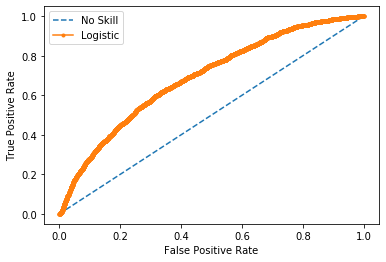

In [84]:
# roc curve and auc

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(pred_ans))]
# predict probabilities
lr_probs = pred_ans

# calculate scores
ns_auc = roc_auc_score(test[target].values, ns_probs)
lr_auc = roc_auc_score(test[target].values, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test[target].values, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test[target].values, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## Resources:

https://deepctr-doc.readthedocs.io/en/latest/Quick-Start.html